In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from annotation_utilities import *
from registration_utilities import *
from conversion import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Local Macbook Pro


In [156]:
stack = 'MD589'

In [157]:
contour_df = DataManager.load_annotation_v4(stack=stack, by_human=True, timestamp='latest', suffix='contours')
contour_df = convert_annotation_v3_original_to_aligned(contour_df, stack=stack)
# contour_df vertices wrt to aligned uncropped lossless image

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07192017084929


In [158]:
# Treat section as a single z value or a whole voxel slice.

In [159]:
downscale = 32

In [160]:
def contours_2d_to_3d(matched_contours, convert_to='aligned', downscale=32):
    """
    Convert matched annotation dataframe entries to contours as a list of 3d array.
    """
    
    contours_3d = []
    for cnt_id, cnt in matched_contours.iterrows():
        fn = cnt['filename']
        if is_invalid(fn=fn, stack=stack) or not isinstance(fn, str): # Sometimes fn is nan, don't know why.
            continue
        
        section = metadata_cache['filenames_to_sections'][stack][fn]
        z = int(np.round(np.mean(DataManager.convert_section_to_z(stack=stack, sec=section, downsample=downscale, z_begin=0, first_sec=1))))
        n = len(cnt['vertices'])
        vertices_on_aligned_3d = np.c_[cnt['vertices']/downscale, z*np.ones((n,))]
        contours_3d.append(vertices_on_aligned_3d)
        
    return contours_3d

In [161]:
contours_grouped_by_name = {}

for name_u in sorted(singular_structures):
#     print name_u
    
    matched_contours = contour_df[(contour_df['name'] == name_u)]
    if len(matched_contours) == 0:
        continue
    
    sections = list(matched_contours['section'])
    print convert_to_left_name(name_u), np.min(sections), np.max(sections), np.max(sections)-np.min(sections)+1
    print sorted(sections)
        
    contours_3d = contours_2d_to_3d(matched_contours, downscale=downscale)
    contours_grouped_by_name[name_u] = contours_3d

for name_u in sorted(paired_structures):
#     print name_u

    matched_contours = contour_df[(contour_df['name'] == name_u) & (contour_df['side'] == 'L')]
    if len(matched_contours) == 0:
        continue

    sections = list(matched_contours['section'])
    if len(sections) > 0:
        print convert_to_left_name(name_u), np.min(sections), np.max(sections), np.max(sections)-np.min(sections)+1
        print sorted(sections)
        
    contours_3d = contours_2d_to_3d(matched_contours, downscale=downscale)
    contours_grouped_by_name[convert_to_left_name(name_u)] = contours_3d
    
    matched_contours = contour_df[(contour_df['name'] == name_u) & (contour_df['side'] == 'R')]
    if len(matched_contours) == 0:
        continue
        
    sections = list(matched_contours['section'])
    if len(sections) > 0:
        print convert_to_right_name(name_u), np.min(sections), np.max(sections), np.max(sections)-np.min(sections)+1
        print sorted(sections)
        
    contours_3d = contours_2d_to_3d(matched_contours, downscale=downscale)
    contours_grouped_by_name[convert_to_right_name(name_u)] = contours_3d
    
    print 

12N_L 206 245 40
[206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245]
AP_L 215 230 16
[215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230]
IC_L 140 305 166
[140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 27

Tz_R 250 275 26
[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275]

VCA_L 94 122 29
[94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122]
VCA_R 333 370 38
[333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370]

VCP_L 103 123 21
[103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 122, 123]
VCP_R 330 359 30
[330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 359]

VLL_L 131 170 40
[131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 16

In [162]:
# for cnt in contours_grouped_by_name['DC_R']:
#     plt.plot(cnt[:,0], cnt[:,1])
# #     plt.show();
# plt.axis('equal');

In [163]:
structure_to_label = {structure: i+1 for i, structure in enumerate(sorted(contours_grouped_by_name.keys()))}
contours_grouped_by_label = {structure_to_label[name]: contours 
                             for name, contours in contours_grouped_by_name.iteritems()}

In [164]:
volume, bbox = contours_to_volume(contours_grouped_by_label=contours_grouped_by_label, 
                                  interpolation_direction='z', return_shell=False)
print bbox
# bbox with wrt aligned uncropped specimen space.

(622, 1042, 155, 502, 128, 503)


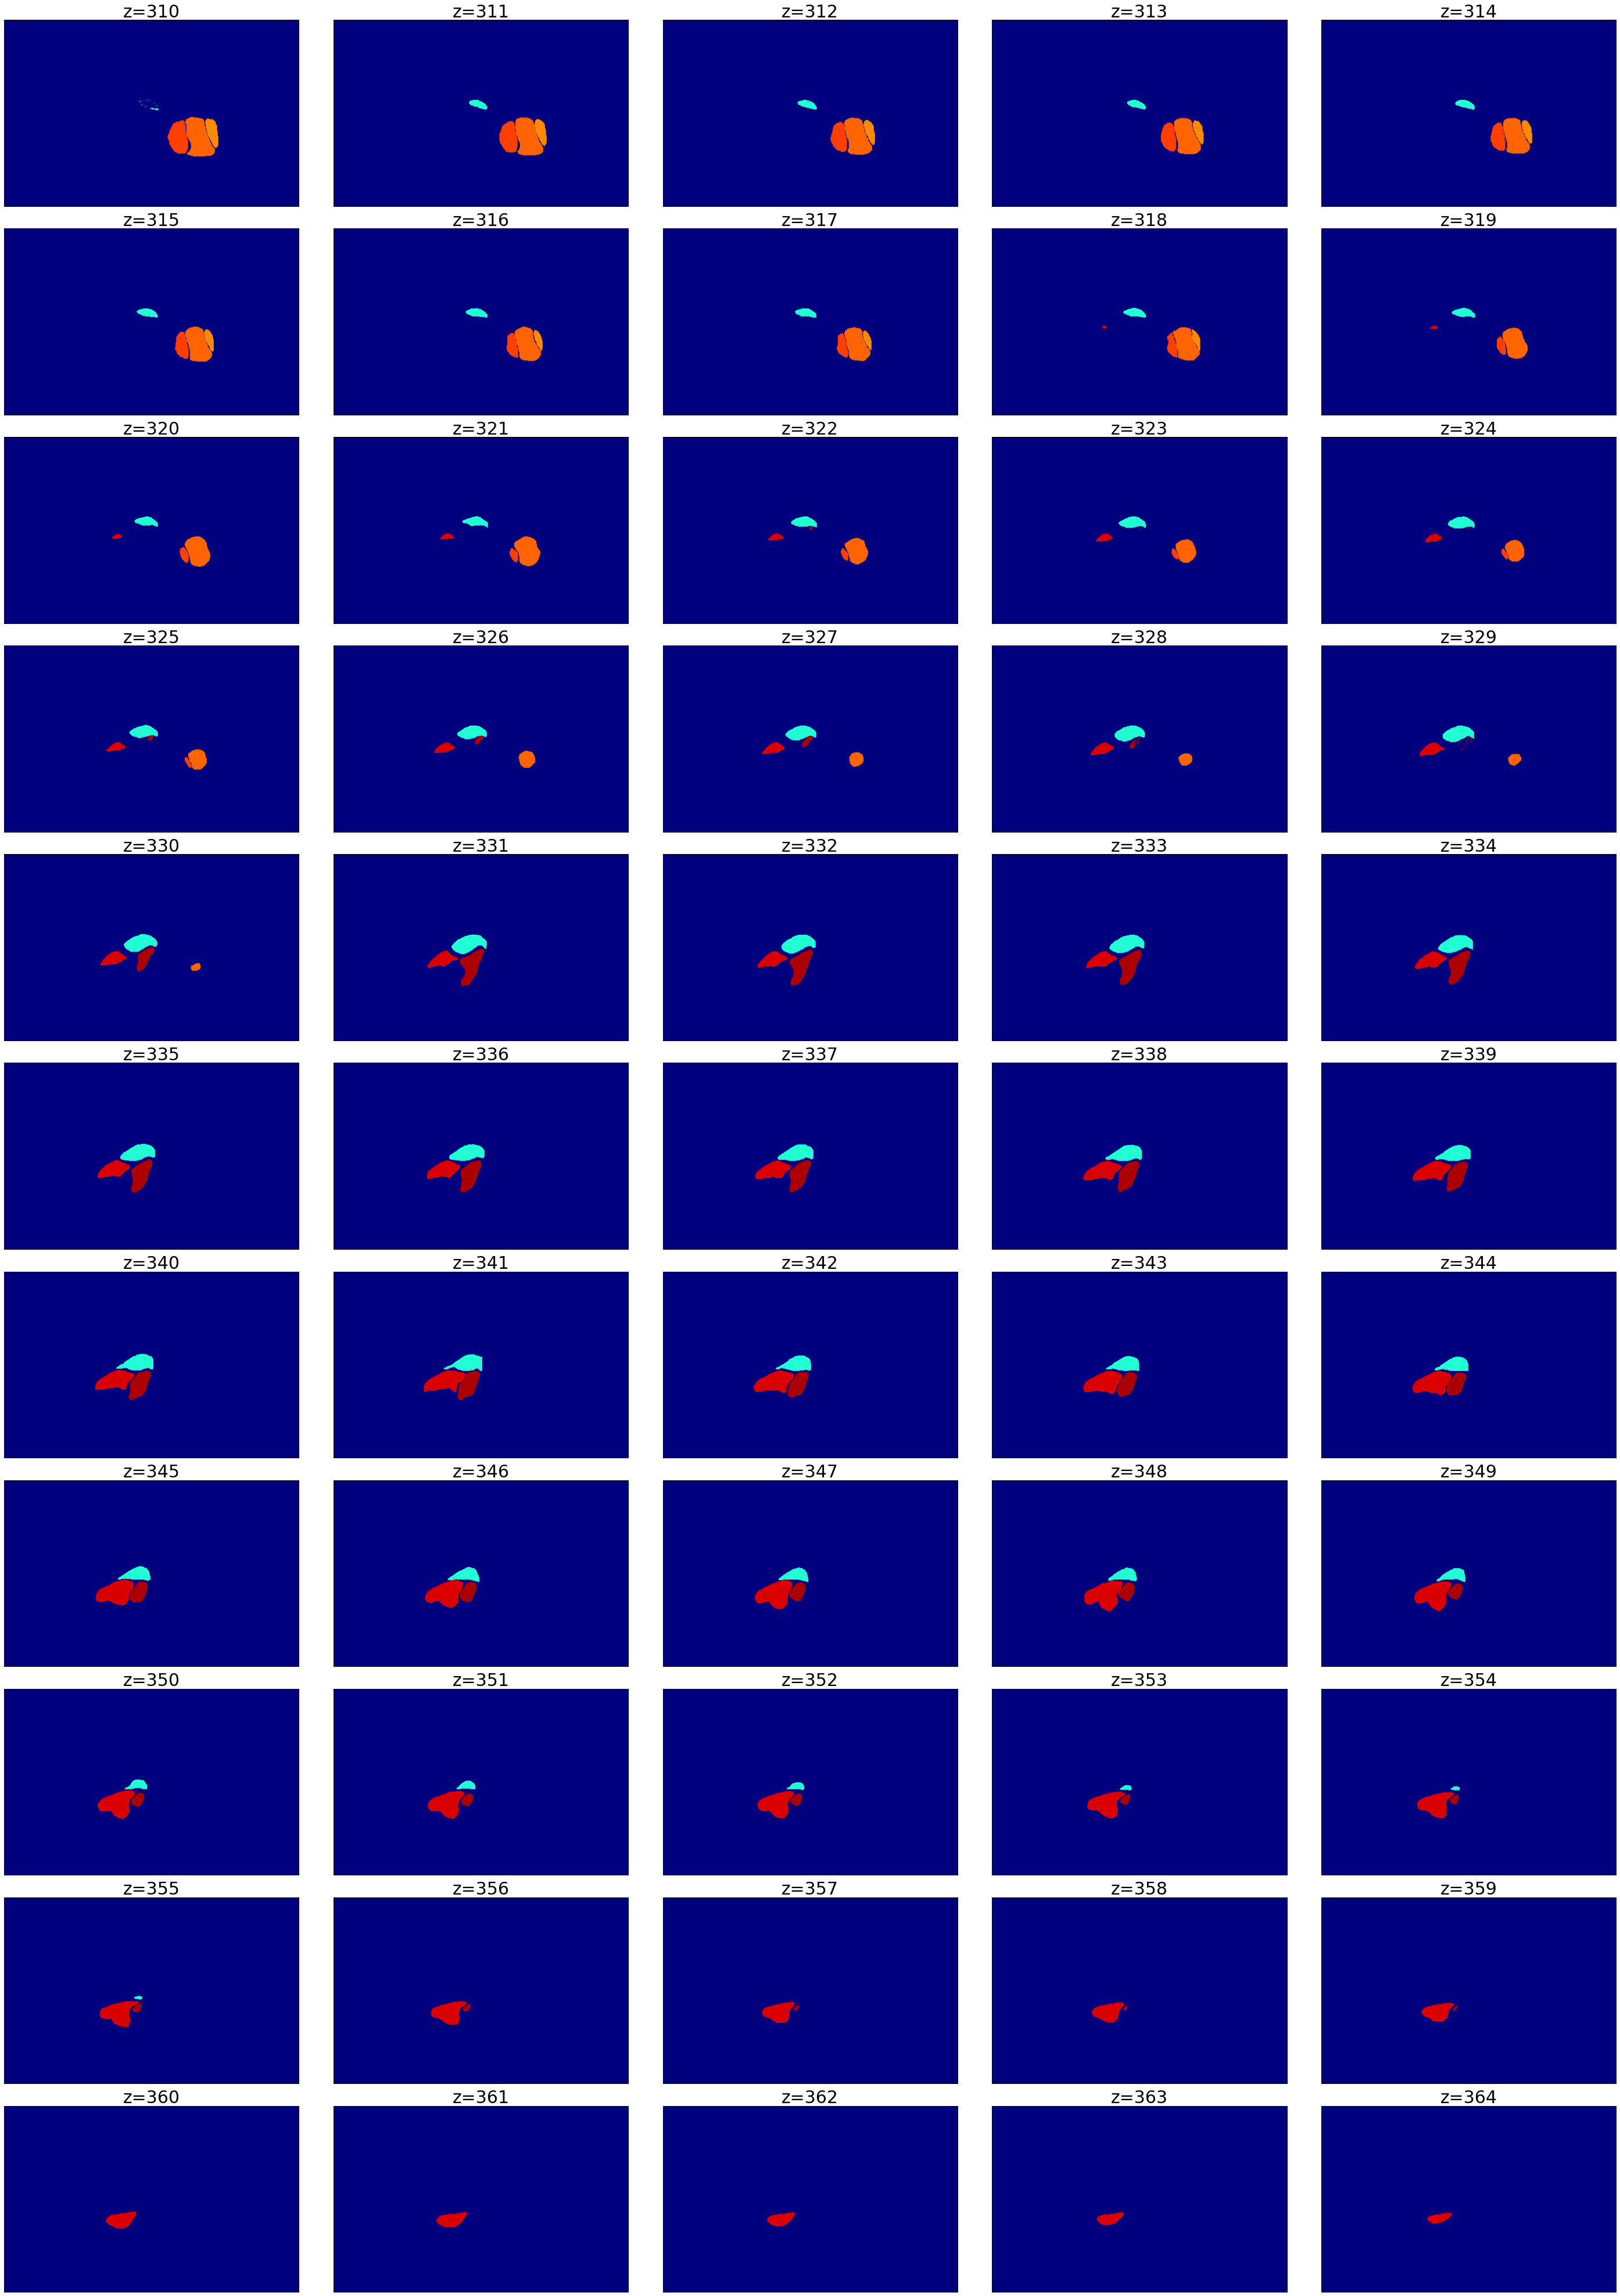

In [114]:
display_volume_sections(volume, every=1, vmin=0, vmax=volume.max(), start_level=310)

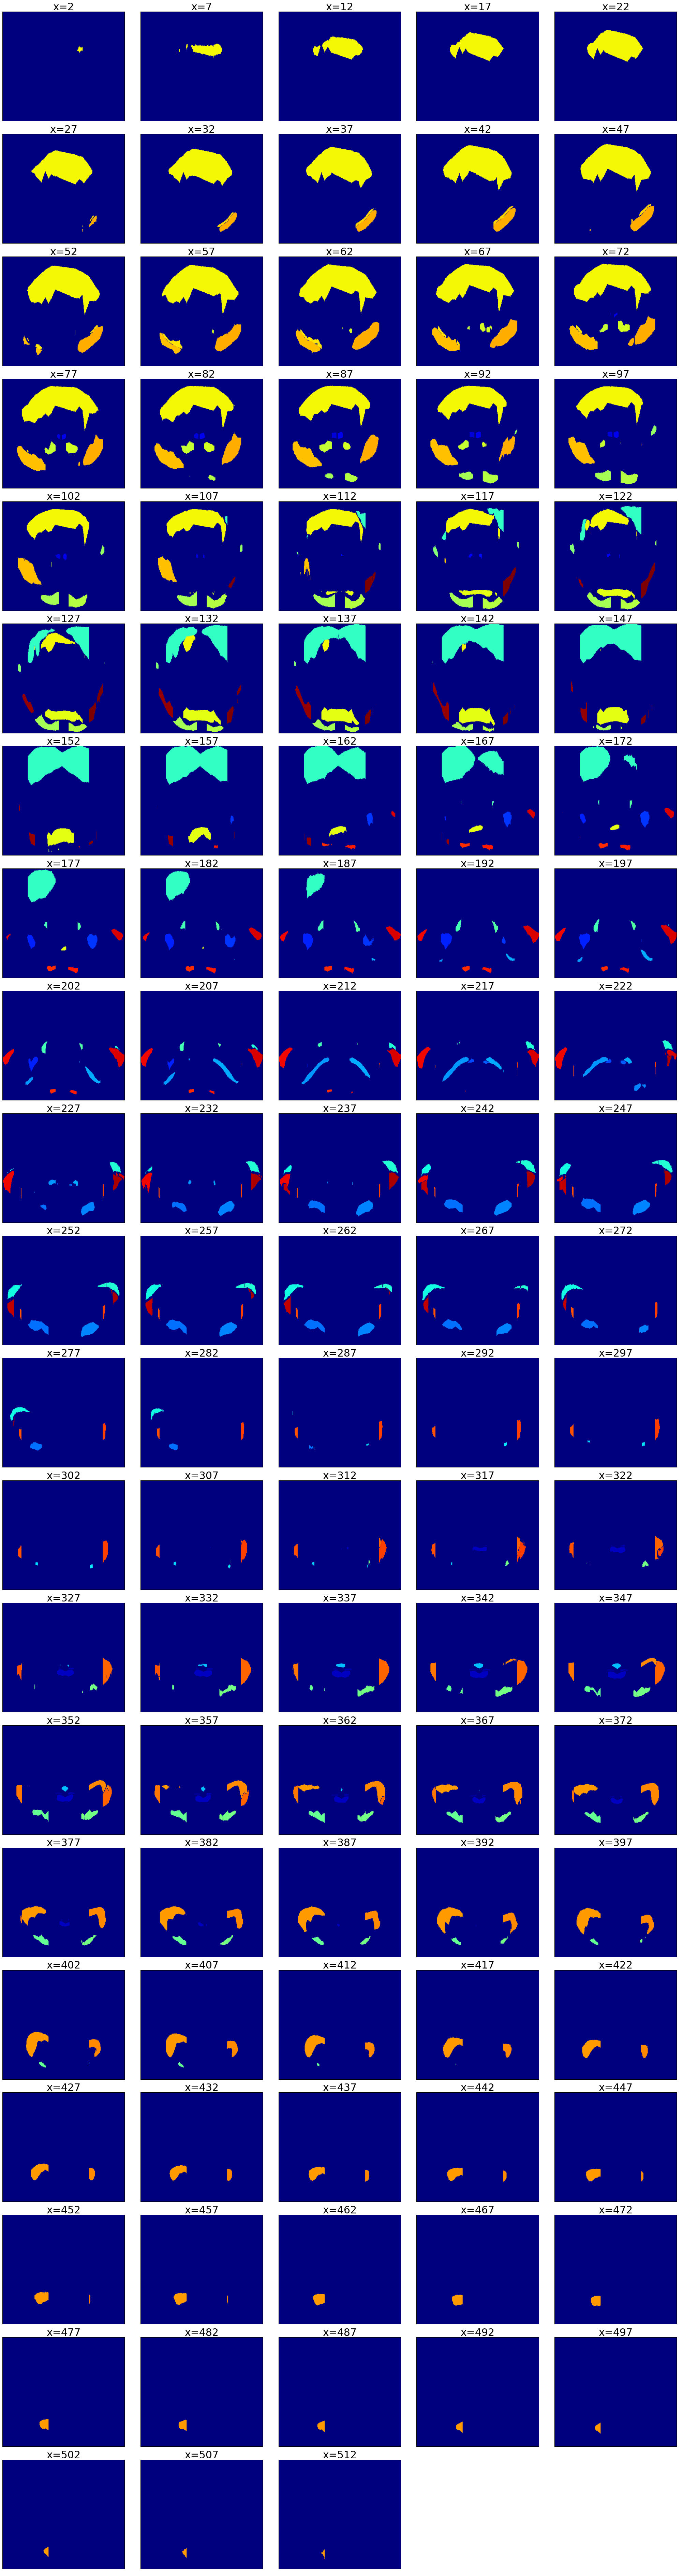

In [110]:
display_volume_sections(volume, every=5, direction='x', vmin=0, vmax=volume.max())

# Output


In [165]:
vol_fp = DataManager.get_annotation_volume_filepath(stack=stack, downscale=downscale)
create_parent_dir_if_not_exists(vol_fp)
bp.pack_ndarray_file(volume, vol_fp)
upload_to_s3(vol_fp)

aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume.bp"


In [166]:
bbox_fp = DataManager.get_annotation_volume_bbox_filepath(stack=stack, downscale=downscale)
np.savetxt(bbox_fp, np.array(bbox)[None], fmt='%d')
upload_to_s3(bbox_fp)

aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume_bbox.txt"


In [167]:
name_label_map_fp = DataManager.get_volume_label_to_name_filepath(stack=stack)

with open(name_label_map_fp, 'w') as f:
    for structure, label in sorted(structure_to_label.items()):
        f.write(structure + ' ' + str(label) + '\n')
        
upload_to_s3(name_label_map_fp)

aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume_nameToLabel.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationVolume/MD589_down32_annotationVolume_nameToLabel.txt"


In [34]:
# with open(os.path.join(volume_dir, '%(stack)s/%(stack)s_down%(down)d_annotationVolume_landmarkBboxes.txt' % \
#                        dict(down=downsample_factor, stack=stack)), 'w') as f:
#     for name_s, label in sorted(name_s_to_label.items()):
#         bbox = bbox_3d(volume == label)
#         f.write(name_s + ' ' + ' '.join(map(str, bbox)) + '\n')

# Decompose as different volumes

In [168]:
volume = DataManager.load_annotation_volume(stack=stack, downscale=downscale)
print volume.shape

label_to_structure, structure_to_label = DataManager.load_volume_label_to_name(stack=stack)

# vol_xmin, vol_xmax, vol_ymin, vol_ymax, vol_zmin, vol_zmax = \
# DataManager.load_original_volume_bbox(stack=stack, volume_type='annotation', downscale=32)

volume_decomposed = annotation_volume_to_score_volume(volume, label_to_structure)

(348, 421, 376)


In [169]:
bbox = DataManager.load_original_volume_bbox(stack=stack, volume_type='annotation')

In [170]:
for structure, v in volume_decomposed.iteritems():
    fp = DataManager.get_original_volume_filepath(stack=stack, downscale=32, structure=structure, volume_type='annotationAsScore')
    create_parent_dir_if_not_exists(fp)
    bp.pack_ndarray_file(v, fp)
    upload_to_s3(fp)
    
    bbox_fp = DataManager.get_original_volume_bbox_filepath(stack=stack, downscale=32, structure=structure, volume_type='annotationAsScore')
    np.savetxt(bbox_fp, np.array(bbox)[None], fmt='%d')
    upload_to_s3(bbox_fp)

aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_LRt_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_LRt_R.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_LRt_R_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_LRt_R_bbox.txt"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_Sp5C_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_Sp5C_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVol

aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_SNR_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_SNR_L_bbox.txt"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_12N.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_12N.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_12N_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_12N_bbox.txt"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreV

aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_5N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_5N_R.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_5N_R_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_5N_R_bbox.txt"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_Sp5I_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_Sp5I_R.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_

aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_Tz_R_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_Tz_R_bbox.txt"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_7n_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_7n_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_7n_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScoreVolume_7n_L_bbox.txt"
aws s3 cp "/home/yuncong/CSHL_volumes/MD589/MD589_down32_annotationAsScoreVolume/score_volumes/MD589_down32_annotationAsScor

# Read

In [4]:
volume = DataManager.load_annotation_volume(stack='MD585', downscale=32)

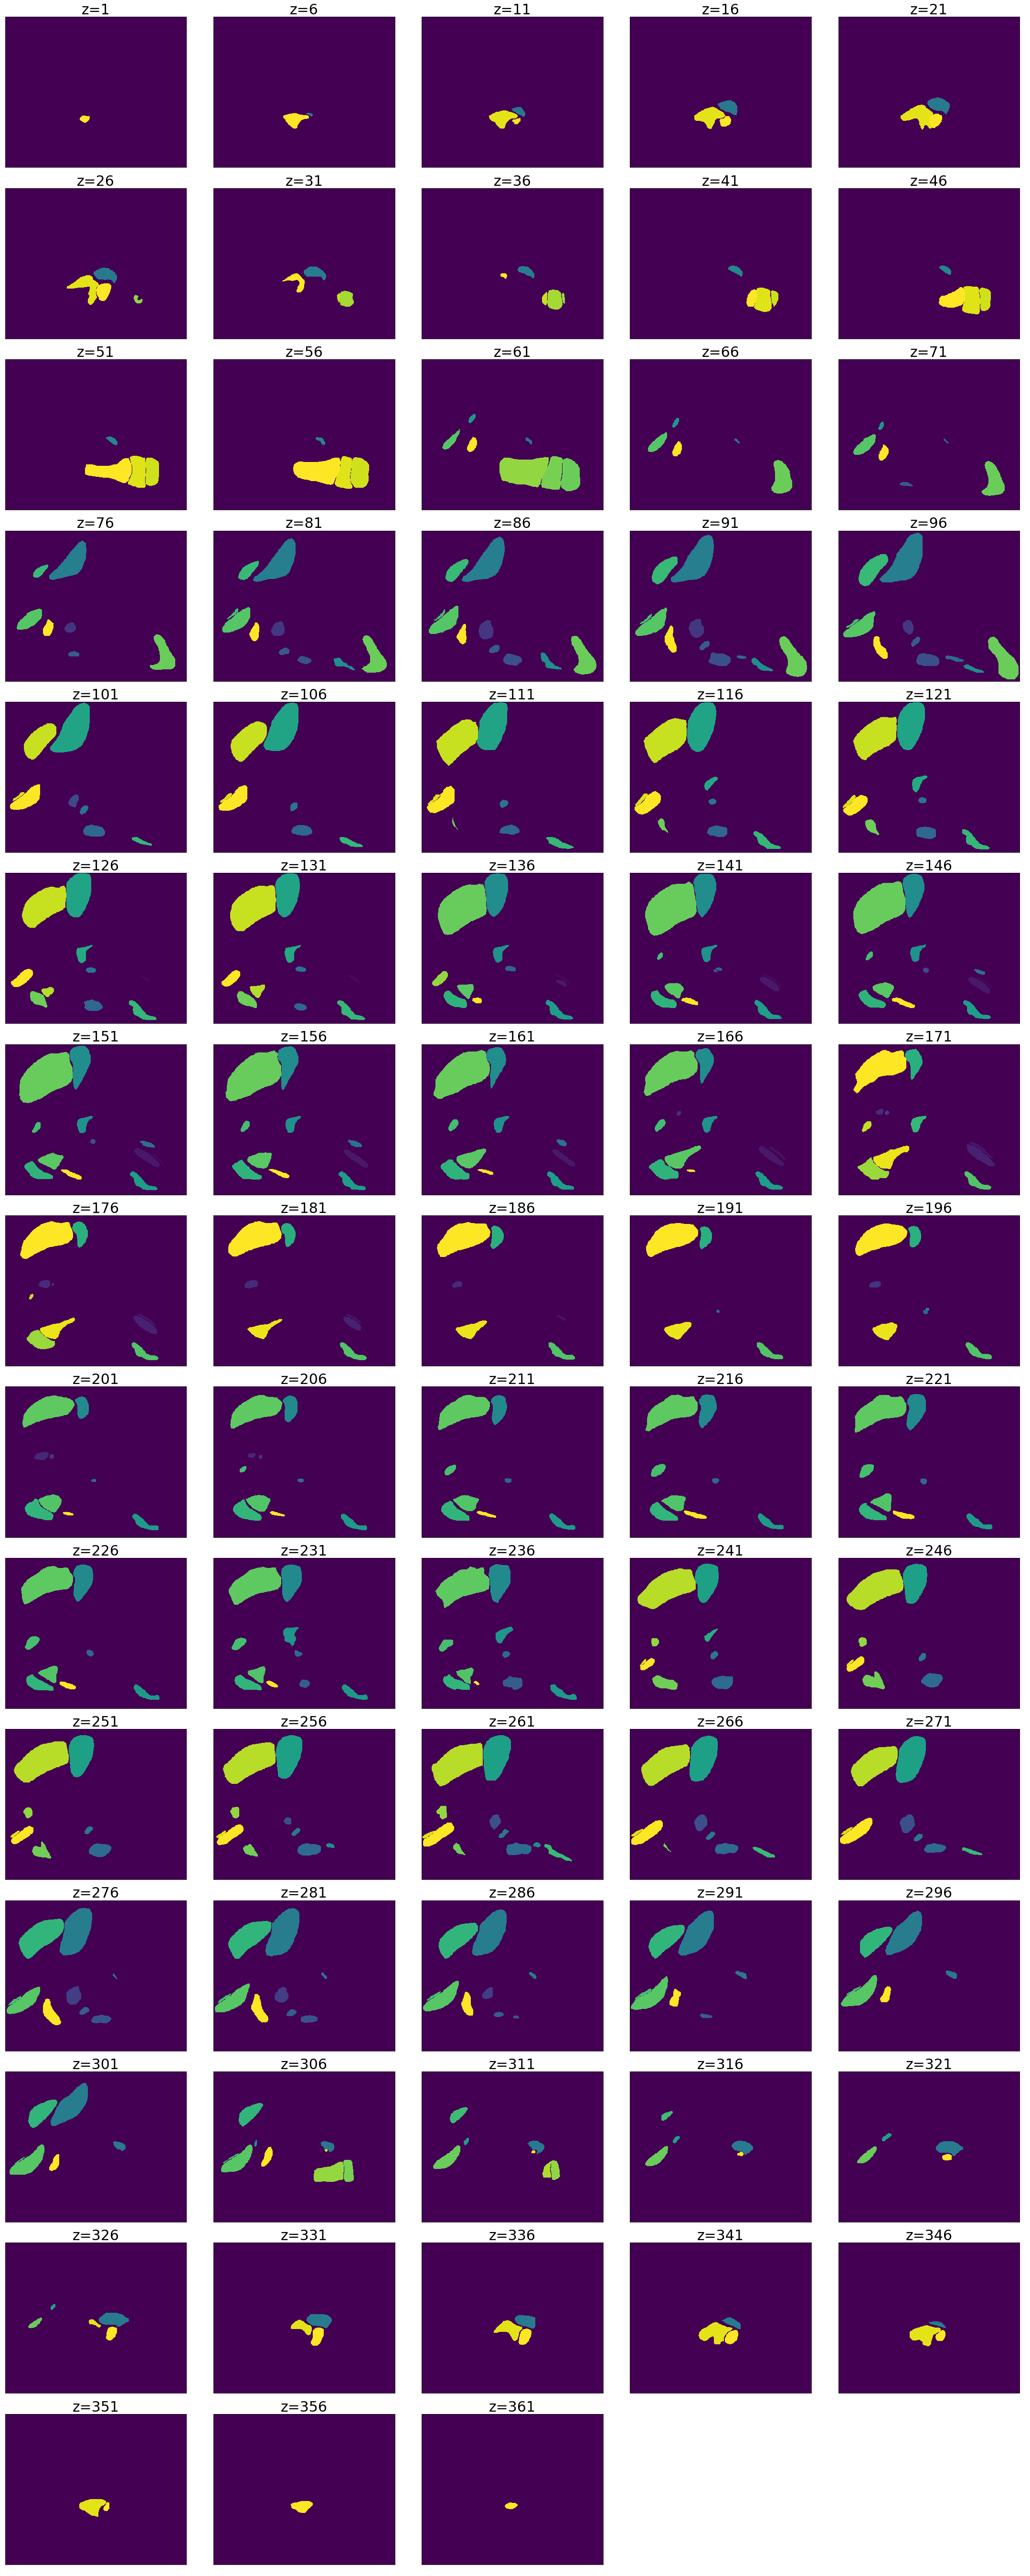

In [5]:
display_volume_sections(vol=volume)